In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skewnorm

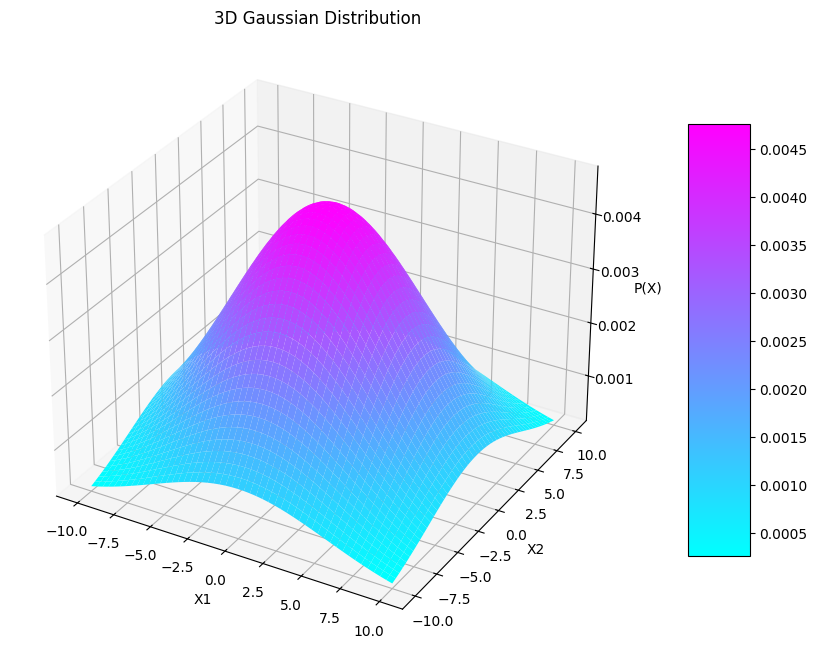

In [10]:
def gaussian_dist(X, mu, sigma):
    P_X = (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-(X - mu)**2 / (2 * sigma**2))
    return P_X

X1 = np.linspace(-10, 10, 1000)
X2 = np.linspace(-10, 10, 1000)
X_1, X_2 = np.meshgrid(X1, X2)

mu1 = np.mean(X1)
mu2 = np.mean(X2)
sigma1 = np.std(X1)
sigma2 = np.std(X2)

X_1, X_2 = np.meshgrid(X1, X2)
Z = gaussian_dist(X_1, mu1, sigma1) * gaussian_dist(X_2, mu2, sigma2)

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X_1, X_2, Z, cmap='cool', edgecolor ='none')
fig.colorbar(surf, ax=ax, shrink=0.7, aspect=7)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel("P(X)")
ax.set_title('3D Gaussian Distribution')
plt.show()

<h3>Feaure Transformation</h3>

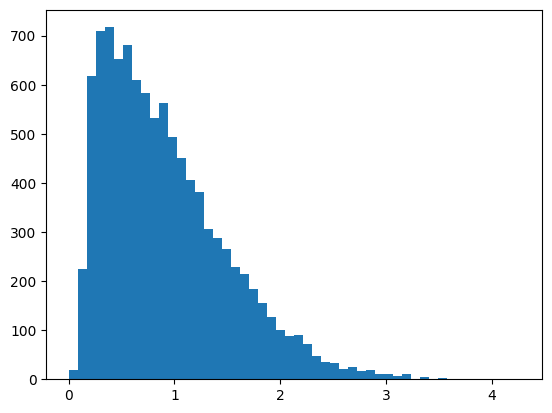

In [3]:
data = skewnorm.rvs(a=20, loc=100, size=10000)
data = ((data - min(data)) / max(data)) * 100 
plt.hist(data, bins=50)
plt.show()

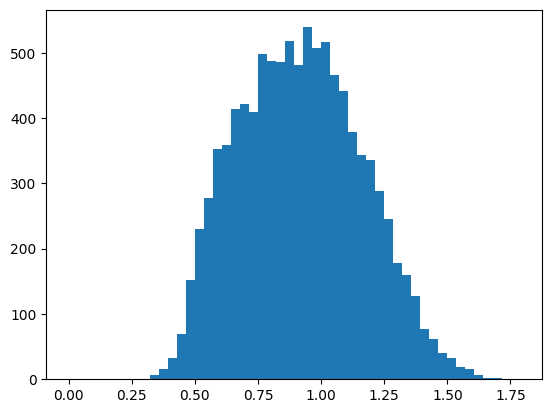

In [4]:
plt.hist(data**.4, bins=50)
plt.show()

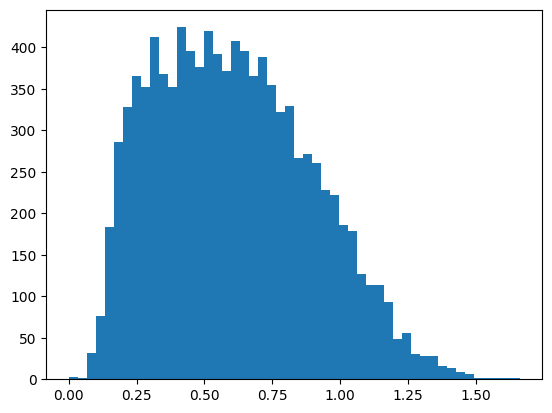

In [5]:
plt.hist(np.log(data+1), bins=50)
plt.show()

In [4]:
X_train = np.load("/home/sam/projects/machine-learning/data/anomaly_detection/X_part1.npy")
X_val = np.load("/home/sam/projects/machine-learning/data/anomaly_detection/X_val_part1.npy")
y_val = np.load("/home/sam/projects/machine-learning/data/anomaly_detection/y_val_part1.npy")
print(X_train[:5, :])
print(X_train.shape)
print(X_val[:5])
print(X_val.shape)
print(y_val[:5])
print(y_val.shape)

[[13.04681517 14.74115241]
 [13.40852019 13.7632696 ]
 [14.19591481 15.85318113]
 [14.91470077 16.17425987]
 [13.57669961 14.04284944]]
(307, 2)
[[15.79025979 14.9210243 ]
 [13.63961877 15.32995521]
 [14.86589943 16.47386514]
 [13.58467605 13.98930611]
 [13.46404167 15.63533011]]
(307, 2)
[0 0 0 0 0]
(307,)


<h3>Anomaly detection Algorithm (Density Estimation)</h3>

In [11]:
def estimate_gaussian(X):
    mu = np.mean(X, axis=0)
    var = np.var(X, axis=0)
    std = np.std(X, axis=0)
    
    stats = {
        "mu": mu,
        "var": var,
        "std": std
    }
    
    return stats

stats = estimate_gaussian(X=X_train)
print(f"mean: {stats['mu']}")
print(f"variance: {stats['var']}")
print(f"standard deviation: {stats['std']}")


mean: [14.11222578 14.99771051]
variance: [1.83263141 1.70974533]
standard deviation: [1.35374717 1.3075723 ]


In [6]:
def multivariate_gaussian(X, mu, var):
    
    k = len(mu)
    
    if var.ndim == 1:
        var = np.diag(var)
        
    X = X - mu
    p = (2* np.pi)**(-k/2) * np.linalg.det(var)**(-0.5) * \
        np.exp(-0.5 * np.sum(np.matmul(X, np.linalg.pinv(var)) * X, axis=1))
    
    return p

In [13]:
def best_threshold(y, y_hat, alpha=1000, not_out=0, out=1): 
    
    best_epsilon = 0
    best_F1 = 0
    F1 = 0
    
    step_size = (max(y_hat) - min(y_hat)) / alpha
    
    for epsilon in np.arange(min(y_hat), max(y_hat), step_size):

        outliers = y_hat < epsilon
        
        tp = np.sum((outliers == out) & (y == out))
        fp = np.sum((outliers == out) & (y == not_out))
        fn = np.sum((outliers == not_out) & (y == out))
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        F1 = (2 * precision * recall) / (precision + recall)
        
        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = epsilon
            
        best_params = {
            "epsilon": best_epsilon, 
            "f1": best_F1
        }
        
    return best_params

In [15]:
stats = estimate_gaussian(X_val)
y_hat = multivariate_gaussian(X_val, stats["mu"], stats["var"])
best_params = best_threshold(y=y_val, y_hat=y_hat, alpha=1000, not_out=0, out=1)
print("best epsilon: ", best_params["epsilon"])
print("best F1: ", best_params["f1"])


best epsilon:  0.00015729462569735177
best F1:  0.8750000000000001


/tmp/ipykernel_4445/4099067498.py:17: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


In [24]:
def predict(X, epsilon, mu, var):
    
    y_hat = multivariate_gaussian(X, mu, var)
    anomalies = []
    indices = []
    
    for i in range(len(y_hat)):
        if y_hat[i] < epsilon:
            anomalies.append(list(X[i]))
            indices.append(i)
                   
    return np.array(anomalies), np.array(indices)

In [25]:
stats = estimate_gaussian(X=X_train)
anomalies, indices = predict(X_train, epsilon=0.00015729462569735177, mu=stats["mu"], var=stats["var"])

print(anomalies)
print(len(anomalies))

[[13.07931049  9.34787812]
 [21.72713402  4.12623222]
 [19.58257277 10.411619  ]
 [23.33986753 16.29887355]
 [18.26118844 17.978309  ]
 [ 4.75261282 24.35040725]]
6


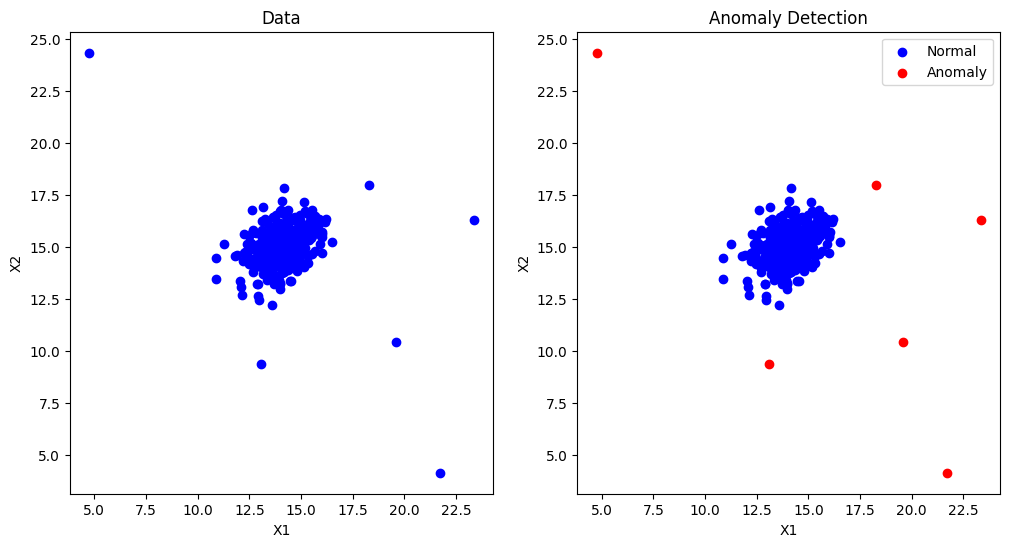

In [33]:
plt.figure(figsize=(12, 6))
X_normal = np.delete(X_train, indices, axis=0)
plt.subplot(1,2,1)
plt.scatter(X_train[:, 0], X_train[:, 1], color="blue")
plt.title("Data")
plt.xlabel("X1")
plt.ylabel("X2")
plt.subplot(1,2,2)
plt.scatter(X_normal[:, 0], X_normal[:, 1], color="blue", label="Normal")
plt.scatter(anomalies[:, 0], anomalies[:, 1], color="red", label="Anomaly")
plt.title("Anomaly Detection")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.show()


In [34]:
X_train = np.load("/home/sam/projects/machine-learning/data/anomaly_detection/X_part2.npy")
X_val = np.load("/home/sam/projects/machine-learning/data/anomaly_detection/X_val_part2.npy")
y_val = np.load("/home/sam/projects/machine-learning/data/anomaly_detection/y_val_part2.npy")
print(X_train[:5, :])
print(X_train.shape)
print(X_val[:5])
print(X_val.shape)
print(y_val[:5])
print(y_val.shape)

[[ 6.65311366e+00  1.36897016e+01  1.75528453e+01 -1.19334974e+01
  -5.75640883e+00  1.54359213e+01 -1.21367520e+01  8.22412257e+00
  -4.88402408e+00  5.34933534e+00  1.73513724e+01]
 [-5.63054206e+00 -1.89376673e+01  1.86446242e+01 -6.15582498e+00
  -2.59888637e+01  1.54095532e+01 -1.65955163e+01  9.45465367e+00
  -2.87717344e+00 -6.00942041e+00  1.92106361e+01]
 [ 9.72152507e+00 -9.98248898e+00  1.55714341e+01 -3.22242657e+01
  -5.59579923e+00  2.43213827e+01  8.32773533e-01  1.07945546e+01
   7.27574802e-01  1.03929750e+01  7.08599490e+00]
 [-4.63576572e+00 -1.07160396e+01  2.03565706e+01 -9.00209733e+00
  -4.92056907e+00 -4.26195747e+00 -1.30582878e+00  9.49980333e-01
  -8.63410656e+00  1.98445438e-01  6.77141253e-03]
 [-1.28410444e+01 -2.03883132e+01  9.49193648e+00 -7.03850017e+00
  -9.92108683e+00 -3.71610505e+00 -9.38473043e+00 -2.32553355e+00
  -1.35185624e+01  1.10070290e+01  1.40032103e+01]]
(1000, 11)
[[ 18.27128267 -12.35926827   5.00096952   1.61147203   1.08859249
   29.

In [37]:
stats = estimate_gaussian(X_val)
y_hat = multivariate_gaussian(X_val, stats["mu"], stats["var"])
best_params = best_threshold(y=y_val, y_hat=y_hat, alpha=1000, not_out=0, out=1)
epsilon = best_params["epsilon"]
print(best_params)

{'epsilon': 1.6620587111948492e-18, 'f1': 0.6153846153846154}


/tmp/ipykernel_4445/4099067498.py:17: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


In [38]:
stats = estimate_gaussian(X=X_train)
anomalies, indices = predict(X_train, epsilon=epsilon, mu=stats["mu"], var=stats["var"])

print(anomalies)
print(len(anomalies))

[[ 15.1078769  -16.43076621  19.70736028 ...   7.2324756   17.22347919
   -2.95685157]
 [ 12.41170635   3.15095858  14.82773369 ...   4.6225471   12.23475097
   23.16729411]
 [ 20.94675383   1.04817038   8.29632435 ... -20.0711297   13.87190556
    4.19788115]
 ...
 [  4.71288957  -5.46801402   7.46378544 ... -11.22135054  -3.26248613
    1.59132222]
 [-12.12007731  -5.84591254  28.95197828 ...  -7.40642279   5.84700046
   20.79701599]
 [  3.05950718  -5.92629827  31.83742321 ...   4.11015915  14.8156443
    9.03532995]]
134
